In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from check_tests import check_test
from scipy.ndimage.filters import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio

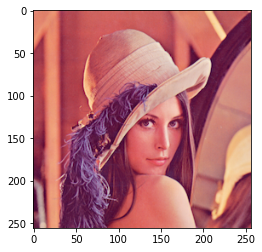

In [2]:
# Считываем и выводим изображение
rgb_img = imread('Lenna.png')
if len(rgb_img.shape) == 3:
    rgb_img = rgb_img[..., :3]
plt.imshow(rgb_img)

In [3]:
def rgb2ycbcr(img):
    """ Переход из пр-ва RGB в пр-во YCbCr
    Вход: RGB изображение
    Выход: YCbCr изображение
    """
    
    a = np.array([[0.299, 0.587, 0.114],
                 [-0.1687, -0.3313, 0.5],
                 [0.5, -0.4187, -0.0813]])
    b = np.array([0, 128, 128])
    
    return np.array([[(b + a.dot(x)).astype(int) for x in y] for y in img])

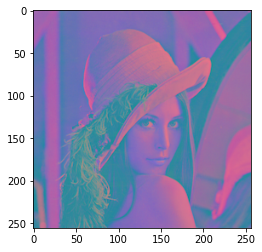

In [4]:
ycbcr_img = rgb2ycbcr(rgb_img)
plt.imshow(ycbcr_img)

In [5]:
def ycbcr2rgb(img):
    """ Переход из пр-ва YCbCr в пр-во RGB
    Вход: YCbCr изображение
    Выход: RGB изображение
    """
    
    a = np.array([[1, 0, 1.402],
                 [1, -0.34414, -0.71414],
                 [1, 1.77, 0]])
    b = np.array([0, 128, 128])
    
    return np.array([[a.dot(x - b).astype(int) for x in y] for y in img])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


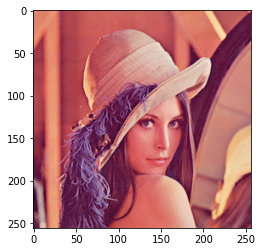

In [6]:
# Возвращаемся обратно к RGB и выводим картинку
rgb_img = ycbcr2rgb(ycbcr_img)
plt.imshow(rgb_img)

#### Размоем цвет и яркость

Факт, являющийся основополагающим в JPEG-сжатии, - это то, что человеческое зрение более чувствительно к изменению яркости, нежели к изменению цвета. Давайте проверим эту гипотезу (скорее, аксиому)!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


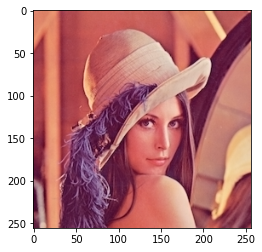

In [7]:
"""Этап 1
Компоненту яркости Y оставим такой, какая она есть.
Цветовые компоненты Cb и Cr размоем с помощью фильтра Гаусса.
Объединим все компоненты в одну картинку и переведем ее обратно в RGB. 
Выедем результат и посмотрим насколько он отличается от исходной картинки.
"""

gauss = np.zeros_like(ycbcr_img)
gauss[:,:,0] = ycbcr_img[:,:,0]
gauss[:,:,1] = gaussian_filter(ycbcr_img[:,:,1], 2)
gauss[:,:,2] = gaussian_filter(ycbcr_img[:,:,2], 2)

plt.imshow(ycbcr2rgb(gauss))

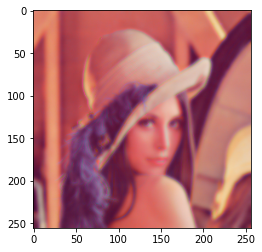

In [8]:
"""Этап 2
Компоненту яркости Y размоем с помощью фильтра Гаусса.
Цветовые компоненты Cb и Cr оставим такими, какие они есть.
Объединим все компоненты в одну картинку и переведем ее обратно в RGB. 
Выедем результат и посмотрим насколько он отличается от исходной картинки.
"""

gauss = np.zeros_like(ycbcr_img)
gauss[:,:,0] = gaussian_filter(ycbcr_img[:,:,0], 2)
gauss[:,:,1] = ycbcr_img[:,:,1]
gauss[:,:,2] = ycbcr_img[:,:,2]

plt.imshow(ycbcr2rgb(gauss))

In [9]:
def downsampling(component):
    """Уменьшаем цветовые компоненты в 2 раза
    Вход: цветовая компонента размера [A, B, 1]
    Выход: цветовая компонента размера [A // 2, B // 2, 1]
    """
    
    #component = gaussian_filter(component, 2)
    
    return np.delete(np.delete(component, np.s_[::2], 1), np.s_[::2], 0)

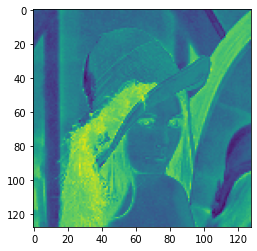

In [10]:
# Уменьшаем Cb компоненту в 2 раза и выводим результат
cb_component = downsampling(ycbcr_img[:,:,1])
plt.imshow(cb_component)

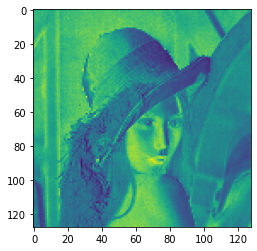

In [11]:
# Уменьшаем Cr компоненту в 2 раза и выводим результат
cr_component = downsampling(ycbcr_img[:,:,2])
plt.imshow(cr_component)

### Дискретное косинусное преобразование
Дискретное косинусное преобразование производится по следующей формуле:

$$G_{u,v} = \frac{1}{4}\alpha(u)\alpha(v)\sum_{x=0}^{7}\sum_{y=0}^{7}g_{x,y}\cos\left[\frac{(2x+1)u\pi}{16}\right]\cos\left[\frac{(2y+1)v\pi}{16}\right],$$

где $g$ - матрица до ДКП, $G$ - после ДКП. $\alpha(u) = \frac{1}{\sqrt{2}}$, если $u=0$, иначе $\alpha(u) = 1$. 

In [12]:
def dct(block):
    """Дискретное косинусное преобразование
    Вход: блок размера 8x8
    Выход: блок размера 8x8 после ДКП
    """

    alpha = lambda a: 1 / np.sqrt(2) if a == 0 else 1
    cs = lambda a, b: np.cos((2 * a + 1) * b * np.pi/ 16)
    f = lambda x, y, u, v: block[x][y] * cs(x, u) * cs(y, v)
    guv = lambda u, v: 1 / 4 * alpha(u) * alpha(v) * sum([f(x, y, u, v) for y in range(8) for x in range(8)])
    g = np.array([[guv(u, v) for v in range(8)] for u in range(8)])

    return g

### Квантование

In [13]:
# Матрица квантования яркости
y_quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Матрица квантования цвета
color_quantization_matrix = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

In [14]:
def quantization(block, quantization_matrix):
    """Квантование
    Вход: блок размера 8x8 после применения ДКП; матрица квантования
    Выход: блок размера 8x8 после квантования. Округление осуществляем с помощью np.round
    """
    
    return np.round(block / quantization_matrix)

### Зигзаг преобразование

In [16]:
def zigzag(block):
    """Зигзаг-сканирование
    Вход: блок размера 8x8
    Выход: список из элементов входного блока, получаемый после его обхода зигзаг-сканированием
    """
    
    flipped = np.flipud(block)
    ret = []
    for i in range(15):
        ret.extend(flipped.diagonal(i - 7) if i % 2 == 0 else reversed(flipped.diagonal(i - 7)))
    
    return ret

### Непосредственно сжатие

In [17]:
def compression(zigzag_list):
    """Сжатие последовательности после зигзаг-сканирования
    Вход: список после зигзаг-сканирования
    Выход: сжатый список в формате, который был приведен в качестве примера в самом начале данного пункта
    """

    ret = []
    n0 = 0
    for x in zigzag_list:
        if x == 0:
            if n0 == 0:
                ret.append(0)
            n0 += 1
            continue
        if n0 != 0:
            ret.append(n0)
            n0 = 0
        ret.append(x)
    
    if n0 != 0:
        ret.append(n0)

    return ret

In [18]:
def jpeg_compression(img, quantization_matrixes):
    """JPEG-сжатие
    Вход: цветная картинка, список из 2-ух матриц квантования
    Выход: список списков со сжатыми векторами: [[compressed_y1,...], [compressed_Cb1,...], [compressed_Cr1,...]]
    """

    y_quantization_matrix, color_quantization_matrix = quantization_matrixes
    
    # Переходим из RGB в YCbCr
    ...
    ycbcr_img = rgb2ycbcr(img)
    # Уменьшаем цветовые компоненты
    ...
    y_component = ycbcr_img[:,:,0]
    cb_component = downsampling(ycbcr_img[:,:,1])
    cr_component = downsampling(ycbcr_img[:,:,2])
    # Делим все компоненты на блоки 8x8 и все элементы блоков переводим из [0, 255] в [-128, 127]
    ...
    y_component -= 128
    cb_component -= 128
    cr_component -= 128
    # Применяем ДКП, квантование, зизгаз-сканирование и сжатие
    ...
    ret = [[] for i in range(3)]
    for i in range(img.shape[0] // 8):
        for j in range(img.shape[1] // 8):
            block = y_component[np.ix_(range(i*8, (i+1)*8), range(j*8, (j+1)*8))]
            block = dct(block)
            block = quantization(block, y_quantization_matrix)
            arr = zigzag(block)
            arr = compression(arr)
            ret[0].append(arr)
    
    for i in range(cb_component.shape[0] // 8):
        for j in range(cb_component.shape[1] // 8):
            block = cb_component[np.ix_(range(i*8, (i+1)*8), range(j*8, (j+1)*8))]
            block = dct(block)
            block = quantization(block, color_quantization_matrix)
            arr = zigzag(block)
            arr = compression(arr)
            ret[1].append(arr)
    
    for i in range(cr_component.shape[0] // 8):
        for j in range(cr_component.shape[1] // 8):
            block = cr_component[np.ix_(range(i*8, (i+1)*8), range(j*8, (j+1)*8))]
            block = dct(block)
            block = quantization(block, color_quantization_matrix)
            arr = zigzag(block)
            arr = compression(arr)
            ret[2].append(arr)
    return ret

In [19]:
result = jpeg_compression(rgb_img, (y_quantization_matrix, color_quantization_matrix))
img_width = rgb_img.shape[0]
img_height = rgb_img.shape[1]

# Декомпрессия

In [20]:
def inverse_compression(compressed_list):
    """Разжатие последовательности
    Вход: сжатый список
    Выход: разжатый список
    """
    
    ret = []
    on0 = False
    for x in compressed_list:
        if on0:
            for i in range(x):
                ret.append(0)
            on0 = False
            continue
        if x == 0:
            on0 = True
            continue
        ret.append(x)

    return ret

In [21]:
def inverse_zigzag(input):
    """Обратное зигзаг-сканирование
    Вход: список элементов
    Выход: блок размера 8x8 из элементов входного списка, расставленных в матрице в порядке их следования в зигзаг-сканировании
    """
    
    block = np.zeros((8,8), dtype=int)
    for i in range(15):
        for x in range(8) if i % 2 == 0 else reversed(range(8)):
            for y in range(8) if i % 2 == 0 else reversed(range(8)):
                if y - x == i - 7:
                    block[x][y] = input.pop(0)
    
    return np.flipud(block)

### Обратное квантование и дискретное косинусное преобразование
Обратное дискретное косинусное преобразование производится по следующей формуле:

$$f_{x,y} = \frac{1}{4}\sum_{u=0}^{7}\sum_{v=0}^{7}\alpha(u)\alpha(v)F_{u,v}\cos\left[\frac{(2x+1)u\pi}{16}\right]\cos\left[\frac{(2y+1)v\pi}{16}\right],$$

где $F$ - матрица до обратного ДКП, $f$ - после обратного ДКП. $\alpha(u) = \frac{1}{\sqrt{2}}$, если $u=0$, иначе $\alpha(u) = 1$.

In [22]:
def inverse_quantization(block, quantization_matrix):
    """Обратное квантование
    Вход: блок размера 8x8 после применения обратного зигзаг-сканирования; матрица квантования
    Выход: блок размера 8x8 после квантования. Округление не производится
    """
    
    return block * quantization_matrix

In [23]:
def inverse_dct(block):
    """Обратное дискретное косинусное преобразование
    Вход: блок размера 8x8
    Выход: блок размера 8x8 после обратного ДКП. Округление осуществляем с помощью np.round
    """

    alpha = lambda a: 1 / np.sqrt(2) if a == 0 else 1
    cs = lambda a, b: np.cos((2 * a + 1) * b * np.pi / 16)
    f = lambda x, y, u, v: alpha(u) * alpha(v) * block[u][v] * cs(x, u) * cs(y, v)
    guv = lambda x, y: 1 / 4 * sum([f(x, y, u, v) for u in range(8) for v in range(8)])
    g = np.array([[guv(x, y) for y in range(8)] for x in range(8)])

    return np.round(g)

In [24]:
def upsampling(component):
    """Увеличиваем цветовые компоненты в 2 раза
    Вход: цветовая компонента размера [A, B, 1]
    Выход: цветовая компонента размера [2 * A, 2 * B, 1]
    """
    
    return np.repeat(np.repeat(component, 2, axis=1), 2, axis=0)

In [25]:
def jpeg_decompression(result, quantization_matrixes):
    """Разжатие изображения
    Вход: result список сжатых данных, список из 2-ух матриц квантования
    Выход: разжатое изображение
    """

    y_quantization_matrix, color_quantization_matrix = quantization_matrixes
    y_component = np.zeros((img_width, img_height))
    cb_component = np.zeros((img_width // 2, img_height // 2))
    cr_component = np.zeros((img_width // 2, img_height // 2))
    
    for i in range(y_component.shape[0] // 8):
        for j in range(y_component.shape[1] // 8):
            arr = result[0].pop(0)
            arr = inverse_compression(arr)
            block = inverse_zigzag(arr)
            block = inverse_quantization(block, y_quantization_matrix)
            block = inverse_dct(block)
            y_component[np.ix_(range(i*8, (i+1)*8), range(j*8, (j+1)*8))] = block
    
    for i in range(cb_component.shape[0] // 8):
        for j in range(cb_component.shape[1] // 8):
            arr = result[1].pop(0)
            arr = inverse_compression(arr)
            block = inverse_zigzag(arr)
            block = inverse_quantization(block, color_quantization_matrix)
            block = inverse_dct(block)
            cb_component[np.ix_(range(i*8, (i+1)*8), range(j*8, (j+1)*8))] = block
    
    for i in range(cr_component.shape[0] // 8):
        for j in range(cr_component.shape[1] // 8):
            arr = result[2].pop(0)
            arr = inverse_compression(arr)
            block = inverse_zigzag(arr)
            block = inverse_quantization(block, color_quantization_matrix)
            block = inverse_dct(block)
            cr_component[np.ix_(range(i*8, (i+1)*8), range(j*8, (j+1)*8))] = block
    
    y_component += 128
    cb_component += 128
    cr_component += 128
    
    img = np.zeros((y_component.shape[0], y_component.shape[1], 3))
    img[:,:,0] = y_component
    img[:,:,1] = upsampling(cb_component)
    img[:,:,2] = upsampling(cr_component)
    
    rgb_img = ycbcr2rgb(img)

    return rgb_img

In [26]:
result_img = jpeg_decompression(result, (y_quantization_matrix, color_quantization_matrix))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


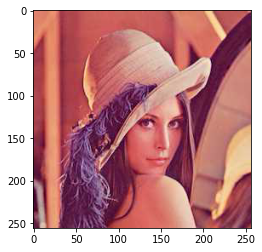

In [27]:
plt.imshow(result_img)

### Таким образом, мы реализовали основную часть pipeline по сжатию с помощью JPEG